In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import tv_model
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import LoadImage

from dataset import Ranzcr

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


CDataset created...
epoch: 0 of 2, train loss: 3.0997235015097986, val loss: 2.9427929525833574, lr: 0.01
epoch: 1 of 2, train loss: 2.8967630480917332, val loss: 2.8646086890889655, lr: 0.01
test loss: 0.012739488723127579
y_pred:
tensor([[-8.0768, -5.1072, -2.1059, -5.7382, -5.5199, -4.1572, -2.9097, -2.4745,
         -1.3422,  1.0402, -5.9003]], device='cuda:0')
 y:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0',
       dtype=torch.float64)


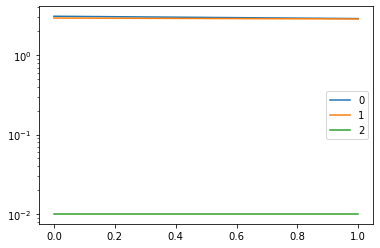

learning time: 0:04:11.735680


In [2]:
ds_params={'train_params': {'embed': [],
                            'image_dir': './data/ranzcr/train',
                            'transform': transforms.Compose([LoadImage(),
                                                             transforms.Resize((224,224)),
                                                             transforms.ToTensor(),
                                                             ]),
                            'target_transform': None}}


model_params = {'model_name': 'resnet18',
                'in_channels': 1,
                'tv_params': {'num_classes': 11}}
    
opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.8,.2)}
sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([Ranzcr], tv_model, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=BCEWithLogitsLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=64, epochs=2)

In [ ]:
ds_params={'train_params': {'embed': [],
                            'image_dir': './data/ranzcr/train',
                            'transform': transforms.Compose([LoadImage(),
                                                             transforms.Resize(224),
                                                             transforms.ToTensor(),
                                                             ]),
                            'target_transform': None}}

ranzcr = Ranzcr(**ds_params['train_params'])

In [ ]:
ranzcr.ds_idx[0]

In [ ]:
ranzcr['71626844098884852779488518078802116425']

In [ ]:
len(ranzcr.ds_idx)